In [1]:
# 한글폰트 불러오기
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False
print("done")

done


# 데이터 수집

직사각형 범위 (A2 사이즈)의 꼭짓점 부분에 ESP32 1개와 각각 연결된 초음파센서 4개를 서로 마주보게 배치하고, 안에 있는 물체를 멈춰있게 또는 느리게 하면 (1), 빠르게 (2), 물체가 없게 (0)로 직접 레이블링 하여 데이터셋을 준비함. (총 변화량을 계산하여 기준을 정한 뒤 레이블링 하는 방법도 있을 것 같지만 현재 프로젝트에서는 정확한 기준은 없이 진행함)

데이터는 0.2초마다 한 번씩 저장됨

timestamp, label, ESP32-1, ESP32-2, ESP32-3, ESP32-4 속성이 있음.

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('datasets/251118_labeled_NH-001_301A.csv')
print("CSV file loaded successfully. First 5 rows:")
print(df.head())

CSV file loaded successfully. First 5 rows:
        timestamp  label  ESP32-1  ESP32-2  ESP32-3  ESP32-4
0  25-11-13 11:12      0     15.0       27       21       28
1  25-11-13 11:12      0     31.0       40       38       47
2  25-11-13 11:12      0     35.0       46       46       50
3  25-11-13 11:12      0     38.0       47       46       51
4  25-11-13 11:12      0     38.0       47       47       51


/tmp/ipykernel_3288/2214834888.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


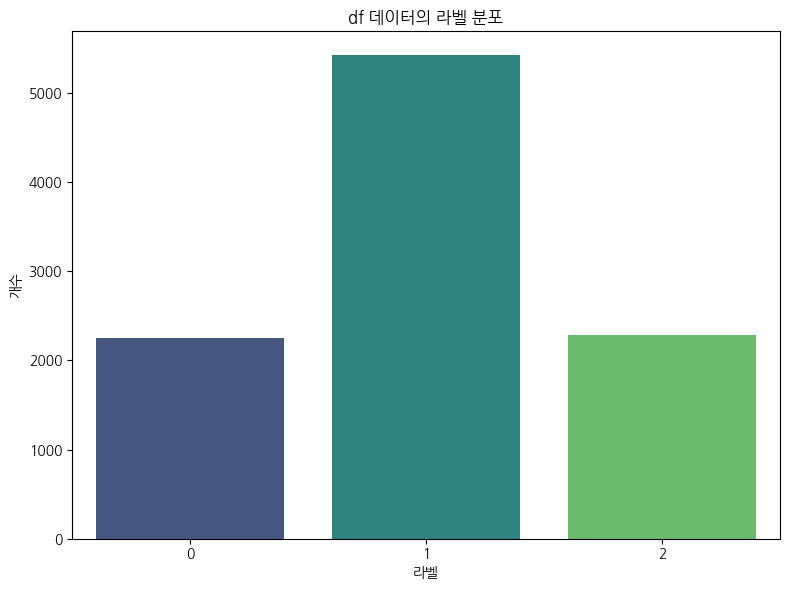

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the value counts of the 'label' column
label_counts = df['label'].value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('df 데이터의 라벨 분포')
plt.xlabel('라벨')
plt.ylabel('개수')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

데이터 수 분포를 고르게 만들고 싶지만, 마땅한 방법이 떠오르지 않음.
다운샘플링 하면 시계열 구간 안에 여러 데이터가 있는 이 데이터셋 특성 상 윈도우 샘플 수가 급감하게 됨. 데이터 수가 압도적으로 많다면 시도해볼만 함.

# 데이터 전처리
-값을 측정하고 저장하는 단계에서 윈도우 사이즈를 설정하여 초음파센서값이 튀는 것을 방지함. (최근 3개의 데이터를 기준으로 값이 정해지게 하고, 한 번에 점프를 허용하는 길이는 건너편 초음파 센서가 있는 거리보다 작거나 같게)

-데이터셋을 저장할 때 센서값 3개 이상이 있어야 저장되는 조건을 걸어 전처리가 용이하게 만듦.

## 0, -1, 비어있는 열을 NaN으로 변환

In [4]:
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

for col in esp_columns:
    df[col] = df[col].replace([0, -1, ''], np.nan)

nan_count = df[esp_columns].isnull().sum().sum()
print(f"\nNaN으로 바뀐 ESP32-N 데이터 수: {nan_count}")


NaN으로 바뀐 ESP32-N 데이터 수: 28


## 데이터의 자료형을 머신러닝/딥러닝에 맞게 변환

In [5]:
for col in esp_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float) # Explicitly cast to float
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(df.dtypes)

timestamp    datetime64[ns]
label                 int64
ESP32-1             float64
ESP32-2             float64
ESP32-3             float64
ESP32-4             float64
dtype: object


/tmp/ipykernel_3288/1081934236.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp'])


## - esp32-1의 NaN은 라벨이 1 또는 2일 때: (39 - esp32-4)로, esp32-4의 NaN은 (39 - esp32-1)로, esp32-2의 NaN은 (39 - esp32-3)로, esp32-3의 NaN은 (39 - esp32-2)로 대체
##- 라벨이 0일 때: 센서의 평균값으로 대체


## 측정한 물체가 지름이 10.5cm인 원기둥이기 때문

In [6]:
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

initial_nan_count = df[esp_columns].isnull().sum().sum()

mask_label_0 = (df['label'] == 0)
mask_label_1_2 = (df['label'].isin([1, 2]))

# NaN 있는 데이터의 라벨이 1 또는 2일 때
max_imputation_iterations = 10
for _ in range(max_imputation_iterations):
    nan_count_this_iteration = 0

    # Impute ESP32-1 using ESP32-4
    impute_mask_1 = mask_label_1_2 & df['ESP32-1'].isnull() & df['ESP32-4'].notnull()
    df.loc[impute_mask_1, 'ESP32-1'] = 39 - df.loc[impute_mask_1, 'ESP32-4']
    nan_count_this_iteration += impute_mask_1.sum()

    # Impute ESP32-4 using ESP32-1
    impute_mask_4 = mask_label_1_2 & df['ESP32-4'].isnull() & df['ESP32-1'].notnull()
    df.loc[impute_mask_4, 'ESP32-4'] = 39 - df.loc[impute_mask_4, 'ESP32-1']
    nan_count_this_iteration += impute_mask_4.sum()

    # Impute ESP32-2 using ESP32-3 and ESP32-1
    impute_mask_2 = mask_label_1_2 & df['ESP32-2'].isnull() & df['ESP32-3'].notnull() & df['ESP32-1'].notnull()
    df.loc[impute_mask_2, 'ESP32-2'] = (df.loc[impute_mask_2, 'ESP32-3'] + df.loc[impute_mask_2, 'ESP32-1']) / 2
    nan_count_this_iteration += impute_mask_2.sum()

    # Impute ESP32-3 using ESP32-2 and ESP32-4
    impute_mask_3 = mask_label_1_2 & df['ESP32-3'].isnull() & df['ESP32-2'].notnull() & df['ESP32-4'].notnull()
    df.loc[impute_mask_3, 'ESP32-3'] = (df.loc[impute_mask_3, 'ESP32-2'] + df.loc[impute_mask_3, 'ESP32-4']) / 2
    nan_count_this_iteration += impute_mask_3.sum()

    if nan_count_this_iteration == 0: # Stop if no NaNs were filled in this iteration
        break

# NaN 있는 데이터의 라벨이 0일 때
column_means = df[esp_columns].mean()
for col in esp_columns:
    impute_mask_0 = mask_label_0 & df[col].isnull()
    df.loc[impute_mask_0, col] = column_means[col]

final_nan_count = df[esp_columns].isnull().sum().sum()
overall_replaced_nan_count = initial_nan_count - final_nan_count

print(f"총 대체된 결측치 수: {overall_replaced_nan_count}")

총 대체된 결측치 수: 28


## 센서값을 하루종일 측정하지는 않았기 때문에

In [7]:
df['time_diff'] = df['timestamp'].diff().dt.total_seconds().round(2)



break_indices = df[df['time_diff'] > 0.2].index

continuous_blocks = []
start_idx = 0

for end_idx in break_indices:
    if end_idx > start_idx:
        continuous_blocks.append(df.iloc[start_idx:end_idx].copy())
    start_idx = end_idx + 1

# Add the last block if any data remains
if start_idx < len(df):
    continuous_blocks.append(df.iloc[start_idx:].copy())

print(f"DataFrame split into {len(continuous_blocks)} continuous blocks.")
if continuous_blocks:
    print(f"Shape of the first block: {continuous_blocks[0].shape}")
else:
    print("No continuous blocks found.")

# Display rows where time_diff is not 0.2 and not NaN
non_0_2_and_not_nan_time_diff = df[(df['time_diff'] != 0.2) & (df['time_diff'].notna())][['time_diff']]
print("\nTime differences neither 0.2 nor NaN along with their indices:")
print(non_0_2_and_not_nan_time_diff)

DataFrame split into 45 continuous blocks.
Shape of the first block: (292, 7)

Time differences neither 0.2 nor NaN along with their indices:
      time_diff
1           0.0
2           0.0
3           0.0
4           0.0
5           0.0
...         ...
9954        0.0
9955        0.0
9956        0.0
9957        0.0
9958        0.0

[9958 rows x 1 columns]


In [8]:
extracted_features = []
seq_windows = []   # 시계열 윈도우 저장용
seq_labels  = []   # 각 윈도우의 라벨

window_size = 8  # 1.6 seconds * (1 sample / 0.2 seconds)
stride = 2       # 0.4 seconds * (1 sample / 0.2 seconds)
esp_columns = [col for col in df.columns if col.startswith('ESP32-')]

print("Initialized variables for feature extraction.")

Initialized variables for feature extraction.


In [9]:
for block in continuous_blocks:
    if len(block) >= window_size:
        for i in range(0, len(block) - window_size + 1, stride):
            window_data = block.iloc[i : i + window_size]

            if len(window_data) == window_size:
                feature_dict = {}
                # ① 통계 특징 추출 (머신러닝용)
                for col in esp_columns:
                    feature_dict[f'{col}_mean']   = window_data[col].mean()
                    feature_dict[f'{col}_std']    = window_data[col].std()
                    feature_dict[f'{col}_min']    = window_data[col].min()
                    feature_dict[f'{col}_max']    = window_data[col].max()
                    feature_dict[f'{col}_median'] = window_data[col].median()

                # ② 윈도우 라벨(mode)
                label_mode = window_data['label'].mode()
                if not label_mode.empty:
                    label_val = label_mode[0]
                else:
                    label_val = np.nan  # 이 경우는 거의 없을 것

                feature_dict['label'] = label_val

                # ③ 시계열 윈도우 그대로 저장 (딥러닝용)
                # shape: (window_size, n_sensors)
                seq_windows.append(
                    window_data[esp_columns].to_numpy(dtype=np.float32)
                )
                seq_labels.append(label_val)

                # ④ 통계 특징은 기존대로 저장 (머신러닝용)
                extracted_features.append(feature_dict)

print(f"Total number of feature windows extracted: {len(extracted_features)}")
print(f"Total number of sequence windows extracted: {len(seq_windows)}")

Total number of feature windows extracted: 4807
Total number of sequence windows extracted: 4807


In [10]:
features_df = pd.DataFrame(extracted_features)

print(f"Shape of the consolidated features DataFrame: {features_df.shape}")
print("\nFirst 5 rows of the consolidated features DataFrame:")
print(features_df.head())

# ====== 여기부터 추가: 시계열 배열 생성 ======
X_seq = np.stack(seq_windows).astype(np.float32)   # (N, window_size, n_sensors)
y_seq = np.array(seq_labels)

print("\n시계열 배열 X_seq, y_seq 생성 완료")
print("X_seq shape:", X_seq.shape)  # 예: (N, 8, 4)
print("y_seq shape:", y_seq.shape)

print(f"Shape of the consolidated features DataFrame: {features_df.shape}")
print(features_df.head())

Shape of the consolidated features DataFrame: (4807, 21)

First 5 rows of the consolidated features DataFrame:
   ESP32-1_mean  ESP32-1_std  ESP32-1_min  ESP32-1_max  ESP32-1_median  \
0        33.875     8.025629         15.0         38.0            38.0   
1        37.625     1.060660         35.0         38.0            38.0   
2        38.000     0.000000         38.0         38.0            38.0   
3        37.875     0.353553         37.0         38.0            38.0   
4        37.625     0.517549         37.0         38.0            38.0   

   ESP32-2_mean  ESP32-2_std  ESP32-2_min  ESP32-2_max  ESP32-2_median  ...  \
0        43.500     7.091242         27.0         47.0            47.0  ...   
1        46.625     0.744024         45.0         47.0            47.0  ...   
2        46.000     2.138090         41.0         47.0            47.0  ...   
3        45.750     2.121320         41.0         47.0            47.0  ...   
4        45.750     2.121320         41.0        

## 타겟 및 특징 분리 (X, y)

### Subtask:
`features_df`에서 'label' 컬럼을 타겟 변수(y)로 분리하고, 나머지 특징 컬럼들을 입력 변수(X)로 정의합니다.


In [11]:
# ================================
# 데이터 분할 및 전처리 (수정된 버전)
# ================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. 타겟과 특성 분리
y = features_df['label']
X = features_df.drop('label', axis=1)

# 2. Train/Val/Test 분할 (80/10/10)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

# 3. 스케일링
scaler = StandardScaler()
X_train_2d = scaler.fit_transform(X_train).astype(np.float32)
X_val_2d = scaler.transform(X_val).astype(np.float32)
X_test_2d = scaler.transform(X_test).astype(np.float32)

# 4. 타겟을 float32로 변환
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

print("=" * 80)
print("데이터셋 준비 완료")
print("=" * 80)
print(f"X_train_2d shape: {X_train_2d.shape}")
print(f"X_val_2d shape: {X_val_2d.shape}")
print(f"X_test_2d shape: {X_test_2d.shape}")

X_train_seq, X_temp_seq, y_train_seq, y_temp_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)
X_val_seq, X_test_seq, y_val_seq, y_test_seq = train_test_split(
    X_temp_seq, y_temp_seq, test_size=0.5, random_state=42, stratify=y_temp_seq
)

# 시계열용 스케일러
scaler_seq = StandardScaler()

n_train, T, F = X_train_seq.shape
n_val   = X_val_seq.shape[0]
n_test  = X_test_seq.shape[0]

# (N, T, F) → (N*T, F)로 펴서 피처 기준 정규화
X_train_flat = X_train_seq.reshape(-1, F)
X_val_flat   = X_val_seq.reshape(-1, F)
X_test_flat  = X_test_seq.reshape(-1, F)

X_train_flat = scaler_seq.fit_transform(X_train_flat)
X_val_flat   = scaler_seq.transform(X_val_flat)
X_test_flat  = scaler_seq.transform(X_test_flat)

# 다시 (N, T, F)로
X_train_3d = X_train_flat.reshape(n_train, T, F).astype(np.float32)
X_val_3d   = X_val_flat.reshape(n_val, T, F).astype(np.float32)
X_test_3d  = X_test_flat.reshape(n_test, T, F).astype(np.float32)

# 라벨도 딥러닝용 이름으로 통일
y_train_dl = y_train_seq
y_val_dl   = y_val_seq
y_test_dl  = y_test_seq

print("\n딥러닝용 3D 시계열 데이터 shape")
print("X_train_3d:", X_train_3d.shape)
print("X_val_3d:  ", X_val_3d.shape)
print("X_test_3d: ", X_test_3d.shape)

# 6. 저장
np.savez_compressed(
    'processed_features.npz',
    X_train_2d=X_train_2d, X_val_2d=X_val_2d, X_test_2d=X_test_2d,
    X_train_3d=X_train_3d, X_val_3d=X_val_3d, X_test_3d=X_test_3d,
    y_train=y_train, y_val=y_val, y_test=y_test
)

print("\n데이터 저장 완료: processed_features.npz")
print("=" * 80)

데이터셋 준비 완료
X_train_2d shape: (3845, 20)
X_val_2d shape: (481, 20)
X_test_2d shape: (481, 20)

딥러닝용 3D 시계열 데이터 shape
X_train_3d: (3845, 8, 4)
X_val_3d:   (481, 8, 4)
X_test_3d:  (481, 8, 4)

데이터 저장 완료: processed_features.npz


In [12]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Get numerical column names from X (all of them in this case)
num_cols = X.columns.tolist()

# Define the preprocessing pipeline for numerical features
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Create a ColumnTransformer to apply the preprocessing
# In this case, all columns are numerical, so we only need one transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols)
    ],
    remainder='passthrough' # Keep other columns if any, though none are expected here
)

# Fit and transform the features
X_processed = preprocessor.fit_transform(X)

print("Preprocessing pipeline defined and applied.")
print(f"Shape of preprocessed X: {X_processed.shape}")

Preprocessing pipeline defined and applied.
Shape of preprocessed X: (4807, 20)


# 모델 선택 및 학습

In [13]:
# ================================
# 머신러닝 모델 학습
# ================================
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
import os

# 현재 작업 디렉토리 기준으로 저장 폴더 설정
BASE_DIR = os.getcwd()
SAVE_MODEL_DIR = os.path.join(BASE_DIR, "saved_models")

# 폴더가 없으면 생성
os.makedirs(SAVE_MODEL_DIR, exist_ok=True)

print("모델 저장 경로:", SAVE_MODEL_DIR)



print("\n【 머신러닝 모델 학습 】")

# RandomForest
rf_model = RandomForestClassifier(random_state=64)
rf_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ RandomForestClassifier 학습 완료")

# SVM
svm_model = SVC(kernel='rbf', gamma='auto', random_state=64)
svm_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ SVC 학습 완료")

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ XGBClassifier 학습 완료")

# KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ KNeighborsClassifier 학습 완료")

# GradientBoosting
gbc_model = GradientBoostingClassifier(random_state=64)
gbc_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ GradientBoostingClassifier 학습 완료")

# Dummy
dummy_model = DummyClassifier(strategy='stratified', random_state=64)
dummy_model.fit(X_train_2d, y_train)  # 2D 데이터 사용
print("✓ DummyClassifier 학습 완료")

# ================================
# 딥러닝 모델 학습
# ================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Conv1D, GlobalMaxPooling1D
import json

print("\n【 딥러닝 모델 학습 】")

# 파라미터 설정
timesteps = X_train_3d.shape[1]  # 1
features = X_train_3d.shape[2]   # 20
num_classes = len(np.unique(y_train))
epochs = 25
batch_size = 32

def train_and_save_model(model_name, model, X_train, y_train, X_val, y_val, epochs, batch_size):
    print(f"\n--- {model_name} Model ---")
    model.summary()

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        verbose=1
    )

    base_name = model_name.lower().replace(" ", "_")
    
    model_path = os.path.join(SAVE_MODEL_DIR, f"{base_name}_model.h5")
    history_path = os.path.join(SAVE_MODEL_DIR, f"{base_name}_training_history.json")
    
    model.save(model_path)
    
    with open(history_path, 'w') as f:
        json.dump(history.history, f)
    
    print(f"{model_name} 모델 학습 및 저장 완료 → {model_path}")

    print(f"{model_name} 모델 학습 및 저장 완료")
    return history

# 모델 정의 및 학습
models = {
    "LSTM": Sequential([
        Input(shape=(timesteps, features)),
        LSTM(units=64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "GRU": Sequential([
        Input(shape=(timesteps, features)),
        GRU(units=64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "Tiny-GRU": Sequential([
        Input(shape=(timesteps, features)),
        GRU(units=32, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ]),
    "Conv1D": Sequential([
        Input(shape=(timesteps, features)),
        Conv1D(64, kernel_size=1, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
}

# 모든 모델 학습 (3D 데이터 사용)
histories = {}
for name, model in models.items():
    histories[name] = train_and_save_model(
        name, model, X_train_3d, y_train, X_val_3d, y_val, epochs, batch_size
    )

모델 저장 경로: /home/gyuha1118/venvs/capstone/code/saved_models

【 머신러닝 모델 학습 】
✓ RandomForestClassifier 학습 완료
✓ SVC 학습 완료


/home/gyuha1118/venvs/capstone/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [10:59:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


✓ XGBClassifier 학습 완료
✓ KNeighborsClassifier 학습 완료
✓ GradientBoostingClassifier 학습 완료
✓ DummyClassifier 학습 완료


2025-11-26 10:59:46.640724: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-26 10:59:47.061342: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-26 10:59:48.511296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.



【 딥러닝 모델 학습 】

--- LSTM Model ---


W0000 00:00:1764122389.120960    3288 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,003 (93.76 KB)

 Trainable params: 24,003 (93.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 54s 437ms/step - accuracy: 0.5501 - loss: 1.0139 - val_accuracy: 0.5239 - val_loss: 1.0247
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ -52s -430501us/step - accuracy: 0.5514 - loss: 1.0014 - val_accuracy: 0.5239 - val_loss: 1.0200
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9989 - val_accuracy: 0.5239 - val_loss: 1.0288
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 1.0000 - val_accuracy: 0.5239 - val_loss: 1.0257
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9987 - val_accuracy: 0.5239 - val_loss: 1.0252
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9966 - val_accuracy: 0.5239 - val_loss: 1.0352
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9967 - val_accuracy: 0.5239 - val_loss: 1.0268
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9959 - val_a

LSTM 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/lstm_model.h5
LSTM 모델 학습 및 저장 완료

--- GRU Model ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        13,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,779 (77.26 KB)

 Trainable params: 19,779 (77.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5506 - loss: 1.0088 - val_accuracy: 0.5239 - val_loss: 1.0226
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 1.0005 - val_accuracy: 0.5239 - val_loss: 1.0255
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9996 - val_accuracy: 0.5239 - val_loss: 1.0253
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9993 - val_accuracy: 0.5239 - val_loss: 1.0250
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9977 - val_accuracy: 0.5239 - val_loss: 1.0277
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9977 - val_accuracy: 0.5239 - val_loss: 1.0295
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9975 - val_accuracy: 0.5239 - val_loss: 1.0250
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5514 - loss: 0.9958 - val_accuracy: 0.

GRU 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/gru_model.h5
GRU 모델 학습 및 저장 완료

--- Tiny-GRU Model ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 32)             │         3,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,939 (31.01 KB)

 Trainable params: 7,939 (31.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5480 - loss: 1.0111 - val_accuracy: 0.5239 - val_loss: 1.0213
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 1.0001 - val_accuracy: 0.5239 - val_loss: 1.0303
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9992 - val_accuracy: 0.5239 - val_loss: 1.0334
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9988 - val_accuracy: 0.5239 - val_loss: 1.0233
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9970 - val_accuracy: 0.5239 - val_loss: 1.0274
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ -52s -430731us/step - accuracy: 0.5514 - loss: 0.9965 - val_accuracy: 0.5239 - val_loss: 1.0245
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9965 - val_accuracy: 0.5239 - val_loss: 1.0247
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9947 - val_accu

Tiny-GRU 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/tiny-gru_model.h5
Tiny-GRU 모델 학습 및 저장 완료

--- Conv1D Model ---


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 8, 64)          │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,659 (26.01 KB)

 Trainable params: 6,659 (26.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5300 - loss: 1.0191 - val_accuracy: 0.5239 - val_loss: 1.0268
Epoch 2/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 1.0008 - val_accuracy: 0.5239 - val_loss: 1.0244
Epoch 3/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9998 - val_accuracy: 0.5239 - val_loss: 1.0238
Epoch 4/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9979 - val_accuracy: 0.5239 - val_loss: 1.0204
Epoch 5/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9964 - val_accuracy: 0.5239 - val_loss: 1.0269
Epoch 6/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9965 - val_accuracy: 0.5239 - val_loss: 1.0253
Epoch 7/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9956 - val_accuracy: 0.5239 - val_loss: 1.0225
Epoch 8/25
121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5514 - loss: 0.9952 - val_accuracy: 0.

Conv1D 모델 학습 및 저장 완료 → /home/gyuha1118/venvs/capstone/code/saved_models/conv1d_model.h5
Conv1D 모델 학습 및 저장 완료


#모델 평가


모델 정확도 평가
RandomForest: 0.9563
SVM: 0.9418
XGBoost: 0.9543
KNN: 0.9397
GradientBoosting: 0.9439
Dummy: 0.4366


LSTM: 0.5572


GRU: 0.5530


Tiny-GRU: 0.5572
Conv1D: 0.5572

정확도 순위
           Model  Accuracy       Model Type
    RandomForest  0.956341 Machine Learning
         XGBoost  0.954262 Machine Learning
GradientBoosting  0.943867 Machine Learning
             SVM  0.941788 Machine Learning
             KNN  0.939709 Machine Learning
            LSTM  0.557173    Deep Learning
        Tiny-GRU  0.557173    Deep Learning
          Conv1D  0.557173    Deep Learning
             GRU  0.553015    Deep Learning
           Dummy  0.436590 Machine Learning


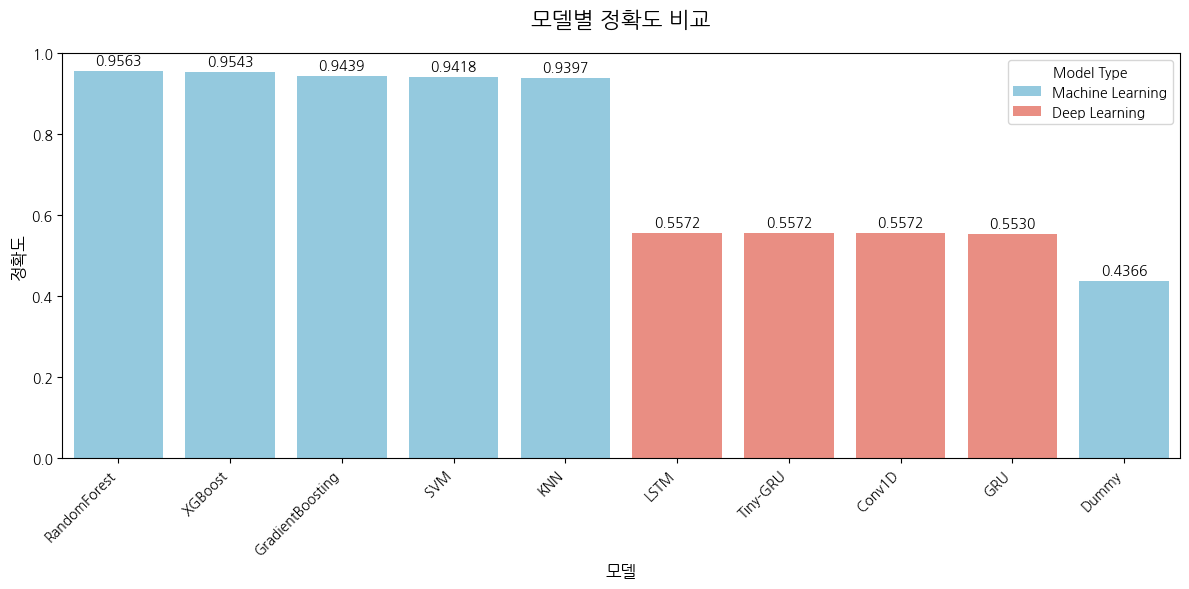


평가 완료


In [14]:
# ================================
# 모든 모델 평가 및 시각화
# ================================
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("\n" + "="*80)
print("모델 정확도 평가")
print("="*80)

# 정확도 저장할 딕셔너리
accuracy_results = {}

# 머신러닝 모델 평가 (2D 데이터 사용)
ml_models = {
    'RandomForest': rf_model,
    'SVM': svm_model,
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'GradientBoosting': gbc_model,
    'Dummy': dummy_model
}

for name, model in ml_models.items():
    y_pred = model.predict(X_test_2d)
    acc = accuracy_score(y_test, y_pred)
    accuracy_results[name] = acc
    print(f"{name}: {acc:.4f}")

# 딥러닝 모델 평가 (3D 데이터 사용)
dl_models = {
    "LSTM":    os.path.join(SAVE_MODEL_DIR, "lstm_model.h5"),
    "GRU":     os.path.join(SAVE_MODEL_DIR, "gru_model.h5"),
    "Tiny-GRU": os.path.join(SAVE_MODEL_DIR, "tiny-gru_model.h5"),
    "Conv1D":  os.path.join(SAVE_MODEL_DIR, "conv1d_model.h5"),
}


for name, path in dl_models.items():
    model = tf.keras.models.load_model(path)
    y_pred = model.predict(X_test_3d, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    acc = accuracy_score(y_test, y_pred_classes)
    accuracy_results[name] = acc
    print(f"{name}: {acc:.4f}")

# 정확도 기준 내림차순 정렬
sorted_results = sorted(accuracy_results.items(), key=lambda x: x[1], reverse=True)
sorted_df = pd.DataFrame(sorted_results, columns=['Model', 'Accuracy'])

# 모델 타입 컬럼 추가
sorted_df['Model Type'] = sorted_df['Model'].apply(lambda x:
    'Deep Learning' if x in dl_models else 'Machine Learning')

print("\n" + "="*80)
print("정확도 순위")
print("="*80)
print(sorted_df.to_string(index=False))

# 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=sorted_df, x='Model', y='Accuracy', hue='Model Type', palette={'Machine Learning': 'skyblue', 'Deep Learning': 'salmon'})
plt.title('모델별 정확도 비교', fontsize=16, pad=20)
plt.xlabel('모델', fontsize=12)
plt.ylabel('정확도', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)

# 막대 위에 정확도 값 표시
for i, (model, acc) in enumerate(sorted_results):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("평가 완료")
print("="*80)



모델별 컨퓨전 매트릭스

=== Confusion Matrix: RandomForest ===
[[104   1   3]
 [  0 263   6]
 [  1  10  93]]


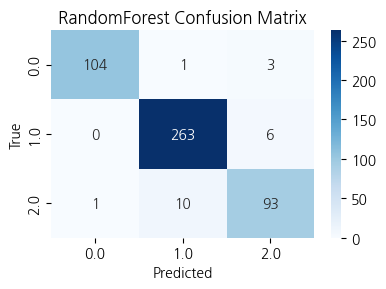


=== Confusion Matrix: SVM ===
[[105   1   2]
 [  0 261   8]
 [  1  16  87]]


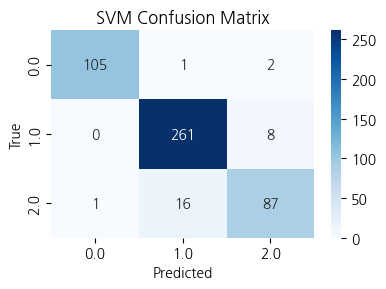


=== Confusion Matrix: XGBoost ===
[[103   1   4]
 [  0 261   8]
 [  2   7  95]]


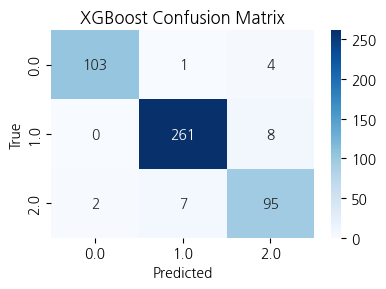


=== Confusion Matrix: KNN ===
[[103   2   3]
 [  0 255  14]
 [  2   8  94]]


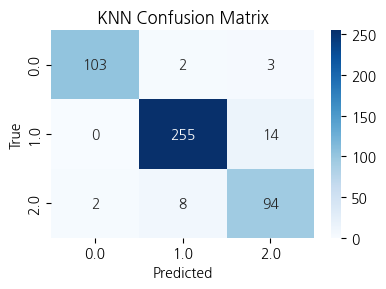


=== Confusion Matrix: GradientBoosting ===
[[103   1   4]
 [  0 259  10]
 [  1  11  92]]


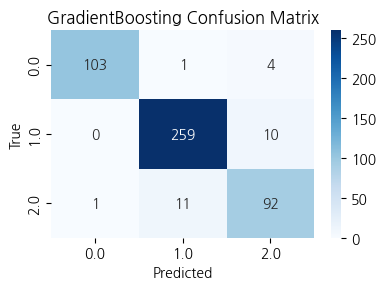


=== Confusion Matrix: Dummy ===
[[ 22  63  23]
 [ 45 164  60]
 [ 20  60  24]]


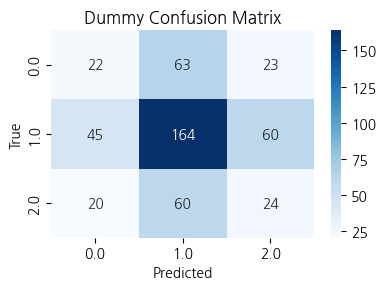


=== Confusion Matrix: LSTM ===
[[  1 107   0]
 [  2 267   0]
 [  3 101   0]]


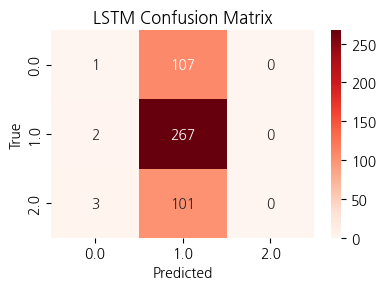


=== Confusion Matrix: GRU ===
[[  2 104   2]
 [  1 263   5]
 [  1 102   1]]


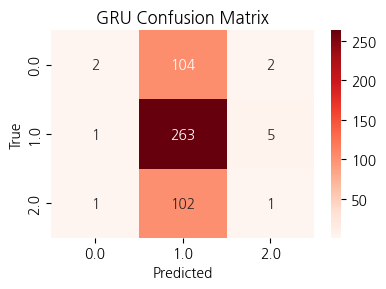


=== Confusion Matrix: Tiny-GRU ===
[[  0 107   1]
 [  0 267   2]
 [  0 103   1]]


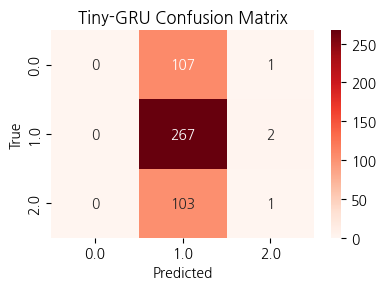


=== Confusion Matrix: Conv1D ===
[[  0 107   1]
 [  1 268   0]
 [  0 104   0]]


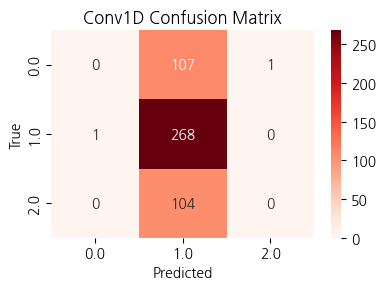

In [15]:
from sklearn.metrics import confusion_matrix

print("\n" + "="*80)
print("모델별 컨퓨전 매트릭스")
print("="*80)

# 클래스 라벨 (예: 0,1,2)
classes = sorted(np.unique(y_test))

# 1) 머신러닝 모델 컨퓨전 매트릭스
for name, model in ml_models.items():
    y_pred = model.predict(X_test_2d)
    cm = confusion_matrix(y_test, y_pred, labels=classes)

    print(f"\n=== Confusion Matrix: {name} ===")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

# 2) 딥러닝 모델 컨퓨전 매트릭스
for name, path in dl_models.items():
    model = tf.keras.models.load_model(path)
    y_pred = model.predict(X_test_3d, verbose=0)
    y_pred_classes = y_pred.argmax(axis=1)
    cm = confusion_matrix(y_test, y_pred_classes, labels=classes)

    print(f"\n=== Confusion Matrix: {name} ===")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=classes, yticklabels=classes)
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()


In [16]:
import numpy as np

# 몇 개까지 출력할지
N_SHOW = 50

# y_test를 numpy 배열로 통일
y_test_arr = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)

# ==============================
# 1) 머신러닝 모델 (예: RandomForest)
# ==============================
ml_model = rf_model          # 다른 모델이면 여기만 바꾸면 됨
X_ml = X_test_2d

proba_ml = ml_model.predict_proba(X_ml)       # (샘플 수, 클래스 수)
proba_ml_round = np.round(proba_ml, 2)        # 소수 둘째자리까지 반올림
y_ml_pred = proba_ml_round.argmax(axis=1)

print("\n=== RandomForest 예측 (반올림된 확률) ===")
for i in range(min(N_SHOW, len(y_test_arr))):
    print(f"샘플 {i}:  실제={y_test_arr[i]},  예측={y_ml_pred[i]},  확률={proba_ml_round[i]}")

# ==============================
# 2) 딥러닝 모델 (예: GRU)
# ==============================
dl_model = tf.keras.models.load_model("gru_model.h5")   # 다른 DL 모델이면 파일명 변경
X_dl = X_test_3d

proba_dl = dl_model.predict(X_dl, verbose=0)
proba_dl_round = np.round(proba_dl, 2)
y_dl_pred = proba_dl_round.argmax(axis=1)

print("\n=== GRU 예측 (반올림된 확률) ===")
for i in range(min(N_SHOW, len(y_test_arr))):
    print(f"샘플 {i}:  실제={y_test_arr[i]},  예측={y_dl_pred[i]},  확률={proba_dl_round[i]}")



=== RandomForest 예측 (반올림된 확률) ===
샘플 0:  실제=2.0,  예측=2,  확률=[0.   0.02 0.98]
샘플 1:  실제=2.0,  예측=2,  확률=[0.   0.02 0.98]
샘플 2:  실제=1.0,  예측=1,  확률=[0.   0.98 0.02]
샘플 3:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 4:  실제=2.0,  예측=2,  확률=[0.   0.03 0.97]
샘플 5:  실제=0.0,  예측=0,  확률=[1. 0. 0.]
샘플 6:  실제=1.0,  예측=1,  확률=[0.   0.81 0.19]
샘플 7:  실제=1.0,  예측=1,  확률=[0.  0.6 0.4]
샘플 8:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 9:  실제=0.0,  예측=0,  확률=[0.99 0.01 0.  ]
샘플 10:  실제=1.0,  예측=1,  확률=[0.  0.9 0.1]
샘플 11:  실제=2.0,  예측=2,  확률=[0.   0.13 0.87]
샘플 12:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 13:  실제=1.0,  예측=1,  확률=[0.   0.94 0.06]
샘플 14:  실제=1.0,  예측=1,  확률=[0.04 0.94 0.02]
샘플 15:  실제=1.0,  예측=1,  확률=[0. 1. 0.]
샘플 16:  실제=1.0,  예측=1,  확률=[0.   0.99 0.01]
샘플 17:  실제=2.0,  예측=2,  확률=[0.   0.01 0.99]
샘플 18:  실제=1.0,  예측=1,  확률=[0.05 0.56 0.39]
샘플 19:  실제=1.0,  예측=1,  확률=[0.   0.84 0.16]
샘플 20:  실제=2.0,  예측=2,  확률=[0. 0. 1.]
샘플 21:  실제=2.0,  예측=2,  확률=[0.   0.09 0.91]
샘플 22:  실제=1.0,  예측=1,  확률=[0.   0.97 0.03]
샘플 23

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'gru_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [19]:
import numpy as np

# y_test를 numpy 배열로 통일
y_test_arr = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)

# 애매한 예측 기준
max_thr = 0.6     # 최대 확률이 이 값보다 작으면 애매
margin_thr = 0.15 # top1 - top2 확률 차이가 이 값보다 작으면 애매

def find_ambiguous_indices(proba, max_thr=0.6, margin_thr=0.15):
    """
    proba: (n_samples, n_classes) 예측 확률
    max_thr: 최대 확률 기준
    margin_thr: top1 - top2 차이 기준
    """
    max_p = proba.max(axis=1)          # 각 샘플의 최대 확률
    sorted_p = np.sort(proba, axis=1)  # 작은 것→큰 것 정렬
    second_p = sorted_p[:, -2]         # 두 번째로 큰 확률
    margin = max_p - second_p          # top1 - top2 차이

    mask = (max_p < max_thr) | (margin < margin_thr)
    idx = np.where(mask)[0]
    return idx, max_p[mask], margin[mask]

# ==============================
# 1) RandomForest (머신러닝)
# ==============================
ml_model = rf_model
X_ml = X_test_2d

proba_ml = ml_model.predict_proba(X_ml)       # (샘플 수, 클래스 수)
amb_idx_ml, amb_max_ml, amb_margin_ml = find_ambiguous_indices(
    proba_ml, max_thr=max_thr, margin_thr=margin_thr
)
y_ml_pred = proba_ml.argmax(axis=1)
proba_ml_round = np.round(proba_ml, 2)

print(f"\n=== RandomForest 애매한 예측 (총 {len(amb_idx_ml)}개) ===")
for idx, max_p, mg in zip(amb_idx_ml, amb_max_ml, amb_margin_ml):
    # X_ml이 DataFrame인지 ndarray인지에 따라 처리
    x_row = X_ml.iloc[idx] if hasattr(X_ml, "iloc") else X_ml[idx]

    print(f"\n[샘플 {idx}]")
    print(f"실제 라벨   : {y_test_arr[idx]}")
    print(f"예측 라벨   : {y_ml_pred[idx]}")
    print(f"최대 확률   : {max_p:.2f}")
    print(f"top1-top2 차: {mg:.2f}")
    print(f"확률 벡터   : {proba_ml_round[idx]}")
    print("입력 데이터 :")
    print(x_row)

# ==============================
# 2) GRU (딥러닝)
# ==============================
dl_model = tf.keras.models.load_model("gru_model.h5")
X_dl = X_test_3d

proba_dl = dl_model.predict(X_dl, verbose=0)
amb_idx_dl, amb_max_dl, amb_margin_dl = find_ambiguous_indices(
    proba_dl, max_thr=max_thr, margin_thr=margin_thr
)
y_dl_pred = proba_dl.argmax(axis=1)
proba_dl_round = np.round(proba_dl, 2)

print(f"\n=== GRU 애매한 예측 (총 {len(amb_idx_dl)}개) ===")
for idx, max_p, mg in zip(amb_idx_dl, amb_max_dl, amb_margin_dl):
    seq = X_dl[idx]  # (타임스텝, 피처 수)

    print(f"\n[샘플 {idx}]")
    print(f"실제 라벨   : {y_test_arr[idx]}")
    print(f"예측 라벨   : {y_dl_pred[idx]}")
    print(f"최대 확률   : {max_p:.2f}")
    print(f"top1-top2 차: {mg:.2f}")
    print(f"확률 벡터   : {proba_dl_round[idx]}")
    print(f"입력 시퀀스 shape: {seq.shape}")  # 예: (8, 4)
    print("입력 시퀀스 값:")
    print(seq)



=== RandomForest 애매한 예측 (총 21개) ===

[샘플 18]
실제 라벨   : 1.0
예측 라벨   : 1
최대 확률   : 0.56
top1-top2 차: 0.17
확률 벡터   : [0.05 0.56 0.39]
입력 데이터 :
[ 0.2772168   0.17609034  0.06370789  0.32708818  0.2860435  -0.03629762
  0.6127298  -0.26585972  0.10445896  0.1225833  -0.44776002  3.1991813
 -1.5197598   1.043073   -0.45732266  0.37105456  2.7732055  -1.1468341
  0.8624116   1.1373835 ]

[샘플 49]
실제 라벨   : 2.0
예측 라벨   : 2
최대 확률   : 0.57
top1-top2 차: 0.14
확률 벡터   : [0.   0.43 0.57]
입력 데이터 :
[ 0.14944592  0.43334863 -0.0536264   0.19962771  0.2860435  -0.7490359
  0.05940286 -0.74253523 -0.61091846 -0.7788514   0.5174765   0.58645195
  0.1597072   0.6919192   0.5578176  -1.5076938   1.1805907  -1.4883231
 -0.31736118 -1.6326644 ]

[샘플 92]
실제 라벨   : 0.0
예측 라벨   : 0
최대 확률   : 0.57
top1-top2 차: 0.19
확률 벡터   : [0.57 0.38 0.05]
입력 데이터 :
[ 1.2834125  -0.12090375  1.2370508   1.091851    1.3928682   1.3993609
  0.5344127   0.7669372   1.2172683   1.4943318   0.7402234   0.35720342
  0.1597072   0.6919


기존 테스트셋 기준 정확도
RandomForest: 0.9563
XGBoost: 0.9543
Tiny-GRU: 0.9480
Conv1D: 0.9459
GradientBoosting: 0.9439
SVM: 0.9418
LSTM: 0.9418
KNN: 0.9397
GRU: 0.9397
Dummy: 0.4366

새 CSV 로드 완료: datasets/TEST_251119_labeled_NH-001_301A.csv
                 timestamp  label  ESP32-1  ESP32-2  ESP32-3  ESP32-4
0  2025-11-13 11:12:01.237      0     15.0       27       21       28
1  2025-11-13 11:12:01.437      0     31.0       40       38       47
2  2025-11-13 11:12:01.637      0     35.0       46       46       50
3  2025-11-13 11:12:01.837      0     38.0       47       46       51
4  2025-11-13 11:12:02.037      0     38.0       47       47       51

새 데이터 NaN 보정 완료

새 데이터 continuous block 개수: 16
새 데이터에서 추출된 윈도우 개수: 5197
features_new_df shape: (5197, 21)
   ESP32-1_mean  ESP32-1_std  ESP32-1_min  ESP32-1_max  ESP32-1_median  \
0        33.875     7.507288         15.0         38.0            38.0   
1        37.625     0.992157         35.0         38.0            38.0   
2        38.000    

[NEW] SVM: 0.9176
[NEW] XGBoost: 0.9683
[NEW] KNN: 0.9352
[NEW] GradientBoosting: 0.9284
[NEW] Dummy: 0.4129


[NEW] LSTM: 0.9228


[NEW] GRU: 0.9282


[NEW] Tiny-GRU: 0.9242
[NEW] Conv1D: 0.9325

기존 테스트셋 vs 새 테스트셋 정확도 비교
Dataset           New Test  Original Test
Model                                    
RandomForest      0.961131       0.956341
XGBoost           0.968251       0.954262
Tiny-GRU          0.924187       0.948025
Conv1D            0.932461       0.945946
GradientBoosting  0.928420       0.943867
SVM               0.917645       0.941788
LSTM              0.922840       0.941788
KNN               0.935155       0.939709
GRU               0.928228       0.939709
Dummy             0.412931       0.436590


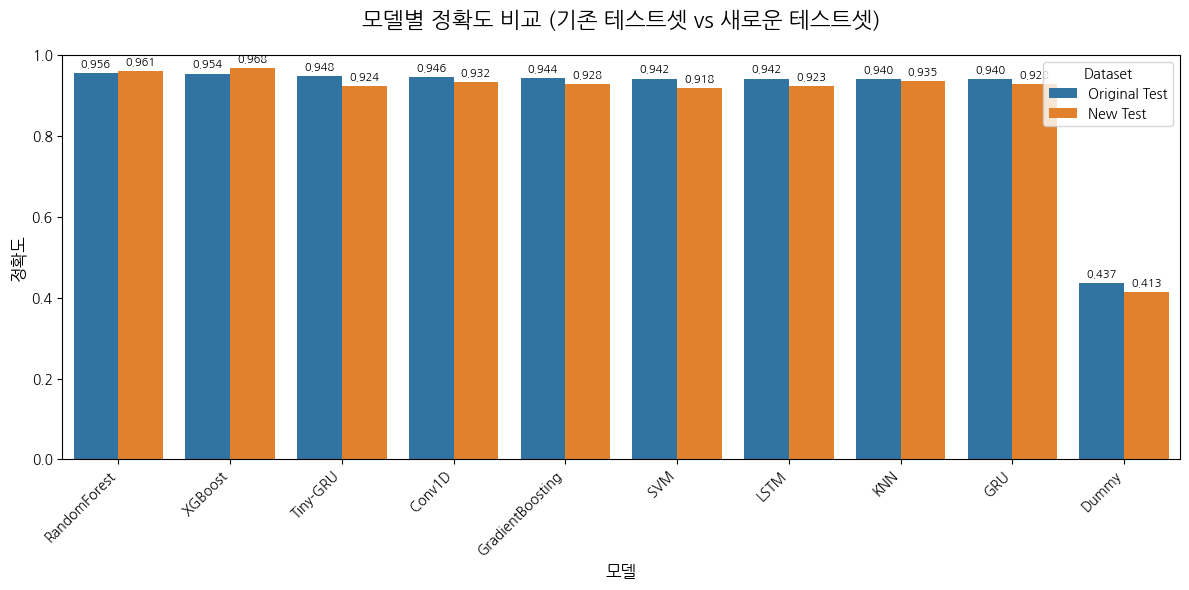

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------
# 0. 기존 테스트셋 결과 백업 (지금 accuracy_results가 기존 테스트셋 기준)
# ---------------------------------------------------
orig_accuracy_results = accuracy_results.copy()
orig_sorted_results = sorted(orig_accuracy_results.items(), key=lambda x: x[1], reverse=True)
model_order = [m for m, _ in orig_sorted_results]

print("\n" + "="*80)
print("기존 테스트셋 기준 정확도")
print("="*80)
for m, acc in orig_sorted_results:
    print(f"{m}: {acc:.4f}")

# ---------------------------------------------------
# 1. 새로운 CSV 로드 (/content/TEST_labeled_NH-001_301A.csv)
#    -> 원래 df 전처리 흐름을 그대로 적용
# ---------------------------------------------------
TEST_CSV_PATH = "datasets/TEST_251119_labeled_NH-001_301A.csv"

df_new = pd.read_csv(TEST_CSV_PATH)
print("\n새 CSV 로드 완료:", TEST_CSV_PATH)
print(df_new.head())

# 1-1) ESP32-* 컬럼 찾기
esp_columns_new = [col for col in df_new.columns if col.startswith('ESP32-')]

# 1-2) 0, -1, '' 를 NaN으로
for col in esp_columns_new:
    df_new[col] = df_new[col].replace([0, -1, ''], np.nan)

# 1-3) float 형으로 변환 + timestamp를 datetime으로
for col in esp_columns_new:
    df_new[col] = pd.to_numeric(df_new[col], errors='coerce').astype(float)
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

# 1-4) NaN 보정 (라벨 1/2: 대칭·평균 보간, 라벨 0: 평균값 대체)
mask_label_0_new   = (df_new['label'] == 0)
mask_label_1_2_new = (df_new['label'].isin([1, 2]))

max_imputation_iterations = 10
for _ in range(max_imputation_iterations):
    nan_count_this_iter = 0

    # ESP32-1 <-> ESP32-4 대칭 (39 기준)
    impute_mask_1 = mask_label_1_2_new & df_new['ESP32-1'].isnull() & df_new['ESP32-4'].notnull()
    df_new.loc[impute_mask_1, 'ESP32-1'] = 39 - df_new.loc[impute_mask_1, 'ESP32-4']
    nan_count_this_iter += impute_mask_1.sum()

    impute_mask_4 = mask_label_1_2_new & df_new['ESP32-4'].isnull() & df_new['ESP32-1'].notnull()
    df_new.loc[impute_mask_4, 'ESP32-4'] = 39 - df_new.loc[impute_mask_4, 'ESP32-1']
    nan_count_this_iter += impute_mask_4.sum()

    # ESP32-2: ESP32-3, ESP32-1 평균
    impute_mask_2 = (
        mask_label_1_2_new
        & df_new['ESP32-2'].isnull()
        & df_new['ESP32-3'].notnull()
        & df_new['ESP32-1'].notnull()
    )
    df_new.loc[impute_mask_2, 'ESP32-2'] = (
        df_new.loc[impute_mask_2, 'ESP32-3'] + df_new.loc[impute_mask_2, 'ESP32-1']
    ) / 2
    nan_count_this_iter += impute_mask_2.sum()

    # ESP32-3: ESP32-2, ESP32-4 평균
    impute_mask_3 = (
        mask_label_1_2_new
        & df_new['ESP32-3'].isnull()
        & df_new['ESP32-2'].notnull()
        & df_new['ESP32-4'].notnull()
    )
    df_new.loc[impute_mask_3, 'ESP32-3'] = (
        df_new.loc[impute_mask_3, 'ESP32-2'] + df_new.loc[impute_mask_3, 'ESP32-4']
    ) / 2
    nan_count_this_iter += impute_mask_3.sum()

    if nan_count_this_iter == 0:
        break

# 라벨 0인 행은 센서별 평균으로 채우기
col_means_new = df_new[esp_columns_new].mean()
for col in esp_columns_new:
    impute_mask_0 = mask_label_0_new & df_new[col].isnull()
    df_new.loc[impute_mask_0, col] = col_means_new[col]

print("\n새 데이터 NaN 보정 완료")

# ---------------------------------------------------
# 2. 연속 구간 나누기 + 윈도우(8샘플, stride=2)로 feature 추출
#    -> 기존 continuous_blocks + extracted_features 로직 그대로
# ---------------------------------------------------
df_new['time_diff'] = df_new['timestamp'].diff().dt.total_seconds().round(2)

break_indices_new = df_new[df_new['time_diff'] > 0.2].index

continuous_blocks_new = []
start_idx = 0

for end_idx in break_indices_new:
    if end_idx > start_idx:
        continuous_blocks_new.append(df_new.iloc[start_idx:end_idx].copy())
    start_idx = end_idx + 1

if start_idx < len(df_new):
    continuous_blocks_new.append(df_new.iloc[start_idx:].copy())

print(f"\n새 데이터 continuous block 개수: {len(continuous_blocks_new)}")

# 윈도우 기반 feature 추출
extracted_features_new = []
window_size = 8   # 1.6초 / 0.2초
stride = 2        # 0.4초 간격

for block in continuous_blocks_new:
    if len(block) >= window_size:
        for i in range(0, len(block) - window_size + 1, stride):
            window_data = block.iloc[i : i + window_size]

            if len(window_data) == window_size:
                feature_dict = {}
                # ESP32-* 컬럼 통계 피처
                for col in esp_columns_new:
                    arr = window_data[col].values
                    feature_dict[f'{col}_mean']   = arr.mean()
                    feature_dict[f'{col}_std']    = arr.std()
                    feature_dict[f'{col}_min']    = arr.min()
                    feature_dict[f'{col}_max']    = arr.max()
                    feature_dict[f'{col}_median'] = np.median(arr)

                # 라벨: 최빈값 (동률이면 숫자 작은 것)
                label_mode = window_data['label'].mode()
                if not label_mode.empty:
                    feature_dict['label'] = label_mode[0]
                else:
                    feature_dict['label'] = np.nan

                extracted_features_new.append(feature_dict)

print(f"새 데이터에서 추출된 윈도우 개수: {len(extracted_features_new)}")

features_new_df = pd.DataFrame(extracted_features_new).dropna(subset=['label'])
print("features_new_df shape:", features_new_df.shape)
print(features_new_df.head())

# ---------------------------------------------------
# 3. 새 데이터 2D/3D 입력 만들기 (기존 scaler 재사용)
# ---------------------------------------------------
y_new = features_new_df['label'].astype(np.float32)
X_new = features_new_df.drop('label', axis=1)

# 기존에 학습해 둔 scaler 사용 (cell 28에서 만든 StandardScaler)
X_new_2d = scaler.transform(X_new).astype(np.float32)

# 딥러닝용 3D: (샘플, time_step=1, feature_dim)
X_new_3d = X_new_2d.reshape(X_new_2d.shape[0], 1, X_new_2d.shape[1])

print("\n새 데이터 2D/3D shape:")
print("X_new_2d:", X_new_2d.shape)
print("X_new_3d:", X_new_3d.shape)
print("y_new   :", y_new.shape)

# ---------------------------------------------------
# 4. 새 데이터로 모든 모델 정확도 평가
# ---------------------------------------------------
new_accuracy_results = {}

print("\n" + "="*80)
print("새 테스트셋 기준 모델 정확도")
print("="*80)

# 4-1) 머신러닝
for name, model in ml_models.items():
    y_pred_new = model.predict(X_new_2d)
    acc_new = accuracy_score(y_new, y_pred_new)
    new_accuracy_results[name] = acc_new
    print(f"[NEW] {name}: {acc_new:.4f}")

# 4-2) 딥러닝
for name, path in dl_models.items():
    dl_model = tf.keras.models.load_model(path)
    y_pred_new = dl_model.predict(X_new_3d, verbose=0)
    y_pred_new_classes = y_pred_new.argmax(axis=1)
    acc_new = accuracy_score(y_new, y_pred_new_classes)
    new_accuracy_results[name] = acc_new
    print(f"[NEW] {name}: {acc_new:.4f}")

# ---------------------------------------------------
# 5. 기존 테스트셋 vs 새 테스트셋 정확도 비교용 DF
# ---------------------------------------------------
rows = []
for m in model_order:
    rows.append({
        "Model": m,
        "Dataset": "Original Test",
        "Accuracy": orig_accuracy_results[m],
        "Model Type": "Deep Learning" if m in dl_models else "Machine Learning",
    })
    rows.append({
        "Model": m,
        "Dataset": "New Test",
        "Accuracy": new_accuracy_results[m],
        "Model Type": "Deep Learning" if m in dl_models else "Machine Learning",
    })

compare_df = pd.DataFrame(rows)
compare_df["Model"] = pd.Categorical(compare_df["Model"],
                                     categories=model_order,
                                     ordered=True)

print("\n" + "="*80)
print("기존 테스트셋 vs 새 테스트셋 정확도 비교")
print("="*80)
print(compare_df.pivot(index="Model", columns="Dataset", values="Accuracy"))

# ---------------------------------------------------
# 6. 정확도 비교 그래프 (기존 그래프와 형태 맞춰서 2셋 비교)
# ---------------------------------------------------
plt.figure(figsize=(12, 6))
sns.barplot(
    data=compare_df,
    x="Model",
    y="Accuracy",
    hue="Dataset",
)
plt.title("모델별 정확도 비교 (기존 테스트셋 vs 새로운 테스트셋)", fontsize=16, pad=20)
plt.xlabel("모델", fontsize=12)
plt.ylabel("정확도", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)

# 막대 위에 정확도 숫자 표시
for i, m in enumerate(model_order):
    acc_orig = orig_accuracy_results[m]
    acc_new  = new_accuracy_results[m]
    plt.text(i - 0.2, acc_orig + 0.01, f"{acc_orig:.3f}", ha="center", va="bottom", fontsize=8)
    plt.text(i + 0.2, acc_new  + 0.01, f"{acc_new:.3f}",  ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()


#모델 배포

주기적으로 데이터셋을 업데이트하여 모델을 학습 후 정확도가 높으면서 라즈베리파이에서 잘 작동할 수 있는 모델을 배포한다.

In [35]:
import joblib, json
import os

MODEL_DIR = "best_model"
os.makedirs(MODEL_DIR, exist_ok=True)

# 1) XGBoost 모델 저장 (이미 했다면 생략 가능)
joblib.dump(xgb_model, os.path.join(MODEL_DIR, "xgb_model.pkl"))

# 2) 스케일러 저장 (반드시 필요)
joblib.dump(scaler, os.path.join(MODEL_DIR, "scaler.pkl"))

# 3) 피처 순서 고정 (학습 때와 동일)
ULTRA_COLS = ["ESP32-1", "ESP32-2", "ESP32-3", "ESP32-4"]
STATS      = ["mean", "std", "min", "max", "median"]
FEATURE_ORDER = [f"{c}_{s}" for c in ULTRA_COLS for s in STATS]

with open(os.path.join(MODEL_DIR, "feature_order.json"), "w") as f:
    json.dump(FEATURE_ORDER, f)
